# Recipe Site Traffic

## Business Problem

With the given data....

At the moment, I choose my favorite recipe from a selection and display that on
the home page. We have noticed that traffic to the rest of the website goes up by as much as 40% if I pick a popular recipe. But I don’t know how to decide if a recipe will be popular. More traffic means more subscriptions so this is really important to the company.

Can your team:
- **Predict which recipes will lead to high traffic?**
- **Correctly predict high traffic recipes 80% of the time?**

## Data

| Column Name | Details                             |
| ----------- | ----------------------------------- |
|recipe       | Numeric, unique identifier of recipe|
|calories     | Numeric, number of calories         |
|carbohydrate | Numeric, amount of carbohydrates in grams|
|sugar        | Numeric, amount of sugar in grams|
|protein      | Numeric, amount of protein in grams|
|category     | Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal').|
|servings     | Numeric, number of servings for the recipe|
|high_traffic | Character, if the traffic to the site was high when this recipe was shown, this is marked with “High”.|

## Load Data

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
df = pd.read_csv('/content/drive/MyDrive/DataCamp/recipe_site_traffic_2212.csv', index_col=0)
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


## Data Validation

####Summary:
The dataset contains 947 rows and 7 columns, with some missing values.  The missing values are imputed and categorical features are updated and/or validated to ensure they have the correct categories.

*   recipe: Index column used to identify the recipes, will not be used for training the models.
*   calories: Imputed the missing values with the mean of calories.
*   carbohydrate: Imputed the missing values with the mean of carbohydrate.
*   sugar: Imputed the missing values with the mean of sugar
*   protein: Imputed the missing values with the mean of protein.
*   category: Does not contain any missing values.  It does contain a category that does not match the expected categories, `['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal']`.  The unexpected category, `Chicken Breast`, was updated to the expected category, `Chicken`.
*   servings: Does not contain any missing values. Some the the values contain the text, `as a snack`.  The unnecessary test was removed, and column datatype was converted to int.
*   high_traffic: As described, the `High` traffic recipes are marked as `High`, and all other recipes are null.  The null values are replaced with `Low`.


In [68]:
# Checking the number of rows and columns in the data
df.shape

(947, 7)

In [69]:
# Looking at the possible null value counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 59.2+ KB


In [70]:
# Check the possible category values
# Expected: (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal')
df['category'].value_counts()

category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

In [71]:
# The actual categories do not match the expected categories. Updating "Chicken Breast" to the expected "Chicken" category.
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')
df['category'].value_counts()

category
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: count, dtype: int64

In [72]:
# fill missing values
df['calories'].fillna(df['calories'].mean(), inplace=True)
df['carbohydrate'].fillna(df['carbohydrate'].mean(), inplace=True)
df['sugar'].fillna(df['sugar'].mean(), inplace=True)
df['protein'].fillna(df['protein'].mean(), inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      947 non-null    float64
 1   carbohydrate  947 non-null    float64
 2   sugar         947 non-null    float64
 3   protein       947 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 59.2+ KB


In [73]:
# Check the possible servings values
df['servings'].value_counts()

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [74]:
# removing the un-needed "as a snack" text and converting the col to an int
df['servings'] = df['servings'].str.replace('as a snack','',regex=False)
df['servings'] = df['servings'].str.strip() # clean up any spaces
df['servings'] = df['servings'].astype(int) # convert to int
df['servings'].value_counts()

servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64

In [75]:
# checking the possible values of the target variable
print(f"Possible High traffic values: {df['high_traffic'].value_counts()}\n")
print(f"Number of Null Values: {df['high_traffic'].isna().sum()}")
print(f"All values are accounted for: {(df['high_traffic'].value_counts().sum() + df['high_traffic'].isna().sum()) == df.shape[0]}")

Possible High traffic values: high_traffic
High    574
Name: count, dtype: int64

Number of Null Values: 373
All values are accounted for: True


If the traffic is high, then it is marked with `High` otherwise is null.

In [76]:
# Filling NA with Low
df['high_traffic'].fillna('Low', inplace=True)
df['high_traffic'].value_counts()

high_traffic
High    574
Low     373
Name: count, dtype: int64

In [77]:
# Data after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      947 non-null    float64
 1   carbohydrate  947 non-null    float64
 2   sugar         947 non-null    float64
 3   protein       947 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   high_traffic  947 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 59.2+ KB


## Exploratory Analysis

### Univariate Analysis

####Summary:
- **Calories, Carbohydrate, Sugar, and Protein all have right-skewed distributions.** To handle this, I will

apply log transformations to reduce skewness.
- **Calories range from 0.14 to 3633.16, with an average of 439.** There is an extreme outlier of 3633.16, which is a very calorie-dense chicken recipe with 4 servings.
- **Carbohydrate ranges from 0.03 to 530.42, with an average of 35.** The outlier of 530.42 is a potato recipe with 4 servings.
- **Sugar ranges from 0.01 to 148.75, with an average of 9.** The outlier is a 1-serving dessert recipe—one very sweet dessert.
- **Protein ranges from 0 to 363.36, with an average of 24.** The outlier is a 6-serving chicken recipe.
- **Most recipes fall under the Chicken, Breakfast, and Beverages categories.**
- **The One Dish Meal category has the fewest recipes.**
- **Most serving sizes are 4.**
- **The fewest serving sizes are 1.**
- **The target variable is High Traffic.** There are more high traffic recipes than low traffic ones. Because of this, I will stratify the data when splitting it.

In [78]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calories,947.0,435.939196,440.394131,0.14,114.410,313.53,576.225,3633.16
carbohydrate,947.0,35.069676,42.724059,0.03,9.135,23.17,42.590,530.42
sugar,947.0,9.046547,14.270029,0.01,1.795,5.05,9.285,148.75
protein,947.0,24.149296,35.356020,0.00,3.465,12.12,28.530,363.36
servings,947.0,3.477297,1.732741,1.00,2.000,4.00,4.000,6.00


In [79]:
# Loooking at the recipes that contain the outliers
df[(df['calories'] == max(df['calories'] )) |
   (df['carbohydrate'] == max(df['carbohydrate'])) |
   (df['sugar'] == max(df['sugar'])) |
   (df['protein'] == max(df['protein']))]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
451,182.76,530.42,5.80,5.01,Potato,4,High
541,60.62,140.98,148.75,5.53,Dessert,1,Low
682,339.38,5.75,10.19,363.36,Chicken,6,High
926,3633.16,29.07,0.35,2.32,Chicken,4,Low


The outliers look valid.  I will keep in mind that hey exist.

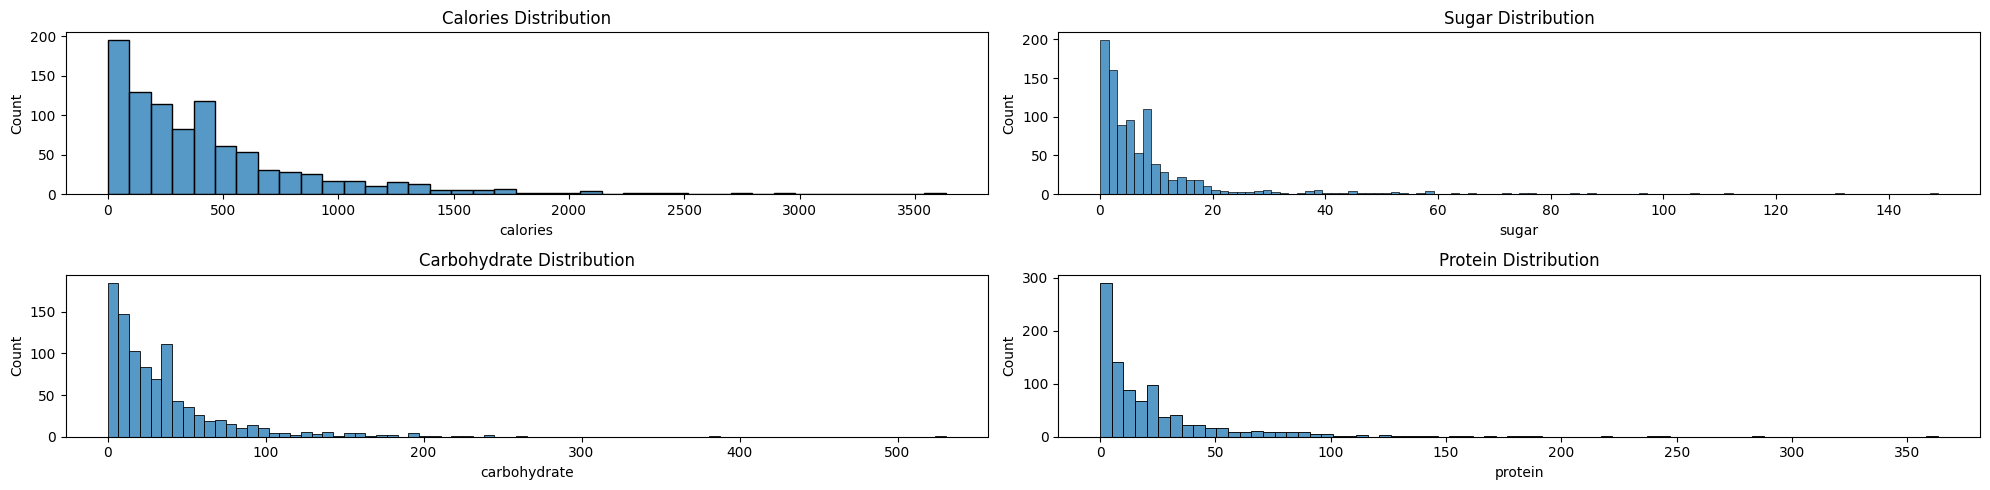

In [80]:
fig, axes = plt.subplots(2,2,figsize=(20,5))
sns.histplot(df['calories'], ax=axes[0,0]).set(title="Calories Distribution")
sns.histplot(df['sugar'], ax=axes[0,1]).set(title="Sugar Distribution")
sns.histplot(df['carbohydrate'], ax=axes[1,0]).set(title="Carbohydrate Distribution")
sns.histplot(df['protein'], ax=axes[1,1]).set(title="Protein Distribution")
plt.tight_layout()
plt.show()

All the numeric cols are right-skewed with outliers.  To prepare for the model I will use log transformation to make it less skewed.  Also I will use the Robust Scaler and models that are able to handle the outliers gracefuly.

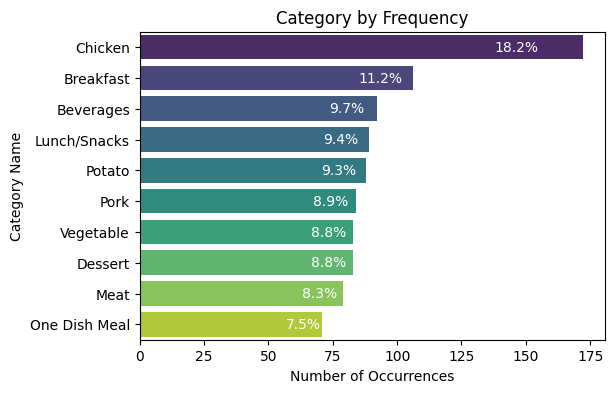

In [81]:
# Get catgory frequencies
category_counts = df['category'].value_counts()

# Calculate the percentage of occurrences
total_occurrences = len(df['category'])
percentage_occurrences = (category_counts / total_occurrences) * 100

# Plot the horizontal bar chart with percentages
plt.figure(figsize=(6, 4))
barplot = sns.barplot(x=category_counts.values, y=category_counts.index,  hue=category_counts.index, legend=False, palette='viridis')

# Annotate bars with percentages
for bar, percentage in zip(barplot.patches, percentage_occurrences):
  plt.text(bar.get_width() - bar.get_width() * 0.20, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%', ha='left', va='center', color='white')

plt.title('Category by Frequency')
plt.xlabel('Number of Occurrences')
plt.ylabel('Category Name')
plt.show()

Most of the recipes are in the Chicken category.  The fewest of the recipes are in the One Dish Meal category.

In [82]:
def plot_counts(df:pd.DataFrame, col:str, title:str, x_labels:list[str]=None, fig_size:tuple[int, int] = (6,4)) -> None:
  """Plots the counts of of unique values in a column

    Parameters:
    df (DataFrame): dataframe that contains the data
    col (str): name of the column
    title (str): title of the plot
    x_labels (list[str]): label of the xticks (Optional)
    fig_size (tuple[str, str]): size of the plot (Optional)

    Returns:
    None

   """
  plt.figure(figsize=fig_size)

  # Plot the countplot with percentages
  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue=col, legend=False, palette='viridis')

  # Set x-axis labels using plt.xticks()
  if x_labels is not None:
    plt.xticks(ticks=[0, 1], labels=x_labels)

  total = len(df[col])

  # Add percentage annotations
  for p in ax.patches:
      height = p.get_height()
      percentage = (height / total) * 100

      ax.annotate(f'{percentage:.1f}%',
                  (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='center',
                  xytext=(0, 5),
                  textcoords='offset points')

  plt.title(title)
  plt.xlabel('')
  plt.ylabel('Count')
  plt.show()

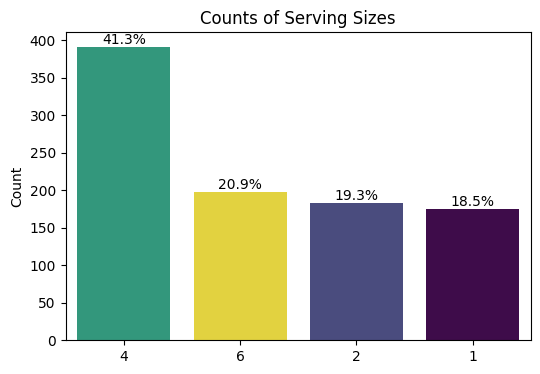

In [83]:
# plot the servings size counts
plot_counts(df, 'servings', 'Counts of Serving Sizes')

Most of the recipes are 4 servings.  The fewest of recipes are 1 serving.

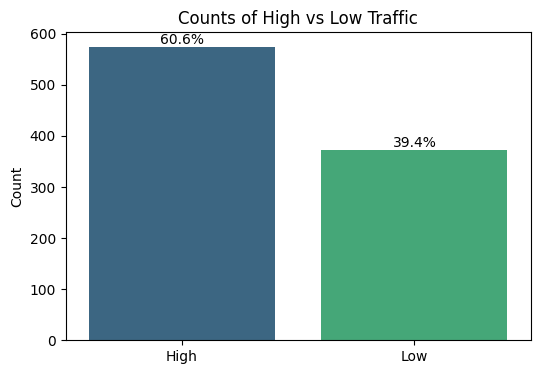

In [84]:
# plot the traffic type counts
plot_counts(df, 'high_traffic', 'Counts of High vs Low Traffic', ['High','Low'])

The target data, high traffic, is mildly imbalanced.  I will stratify when splitting the data.

### Multivariate Analysis

####Summary:
- There are weak correlations with numeric recipe metrics (protein, sugar, carbohydrate, calories) and the web traffic types.
- There is a weak positive correlation between calories and protein.
- There is also a very weak correlation between carbohydrate and sugar.
- There are strong correlations between the recipe category and web traffic type.
- The categories that drive the highest traffic are **Vegetable, Potato, Pork, One Dish Meal, and Meat.**
- The lowest drivers of traffic are Beverages and Breakfast.
- The top 5 categories are also the lowest in contributing to the low traffic.
- Chicken also drives high traffic **but** more than likely drives low traffic as well.
- Most of the high traffic recipes are 4 servings.
- The least driver of traffic recipes are 1 serving.

At this point, my first recommendation will be to show more 4-serving Vegetable, Potato, Pork, One Dish Meal, and Meat recipes.


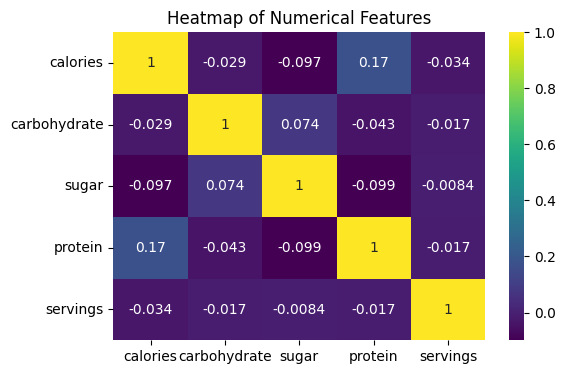

In [85]:
# plot heatmap to look for any correlations
plt.figure(figsize=(6, 4))
sns.heatmap(data=df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title('Heatmap of Numerical Features')
plt.show()

There are no stron correlations.  Some weak positive ones between (protein, calories) and (sugar, carbohydrate)

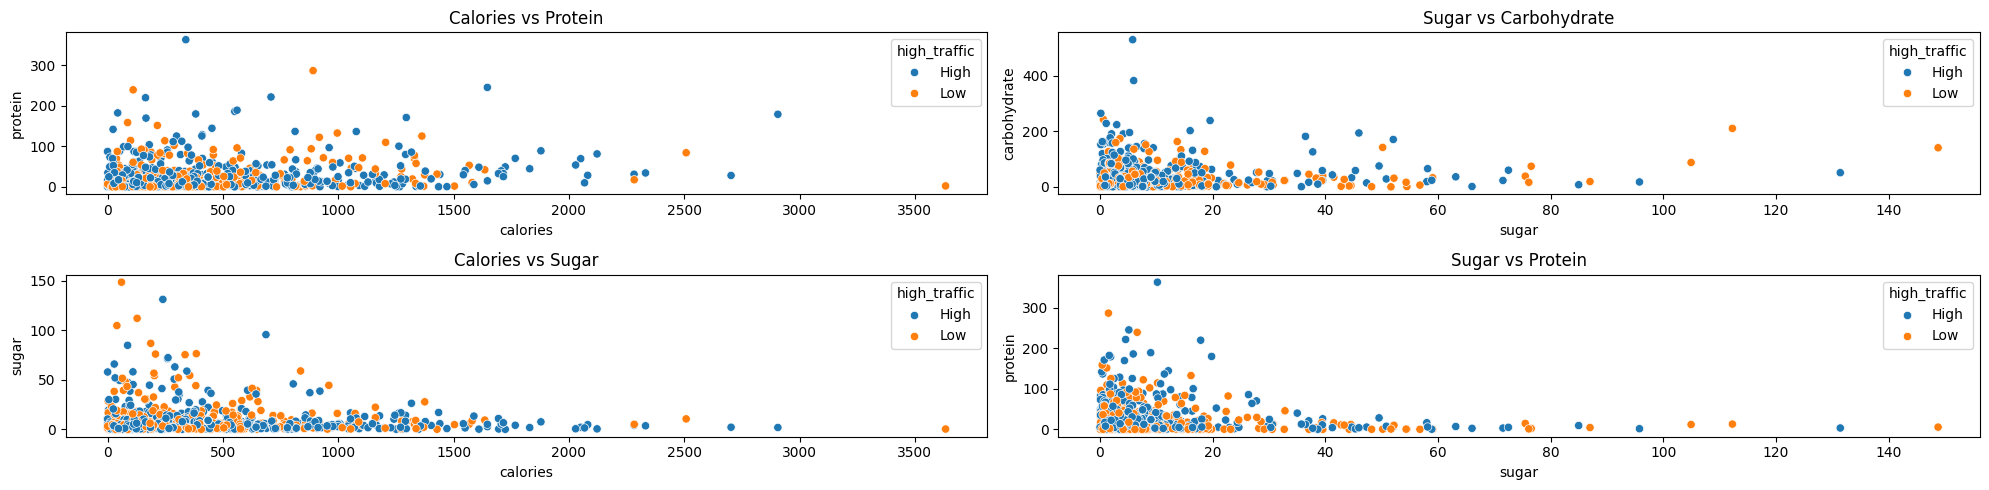

In [86]:
# Looking for correlations, although according to the heatmap there are not any strong ones
fig, axes = plt.subplots(2,2,figsize=(20,5))
sns.scatterplot(data=df, x='calories', y='protein', hue='high_traffic', ax=axes[0,0]).set(title='Calories vs Protein')
sns.scatterplot(data=df, x='sugar', y='carbohydrate', hue='high_traffic', ax=axes[0,1]).set(title='Sugar vs Carbohydrate')
sns.scatterplot(data=df, x='calories', y='sugar', hue='high_traffic', ax=axes[1,0]).set(title='Calories vs Sugar')
sns.scatterplot(data=df, x='sugar', y='protein', hue='high_traffic', ax=axes[1,1]).set(title='Sugar vs Protein')
plt.tight_layout()
plt.show()

As expected, I don't see any strong correlations with the target, high traffic, and the numeric features.

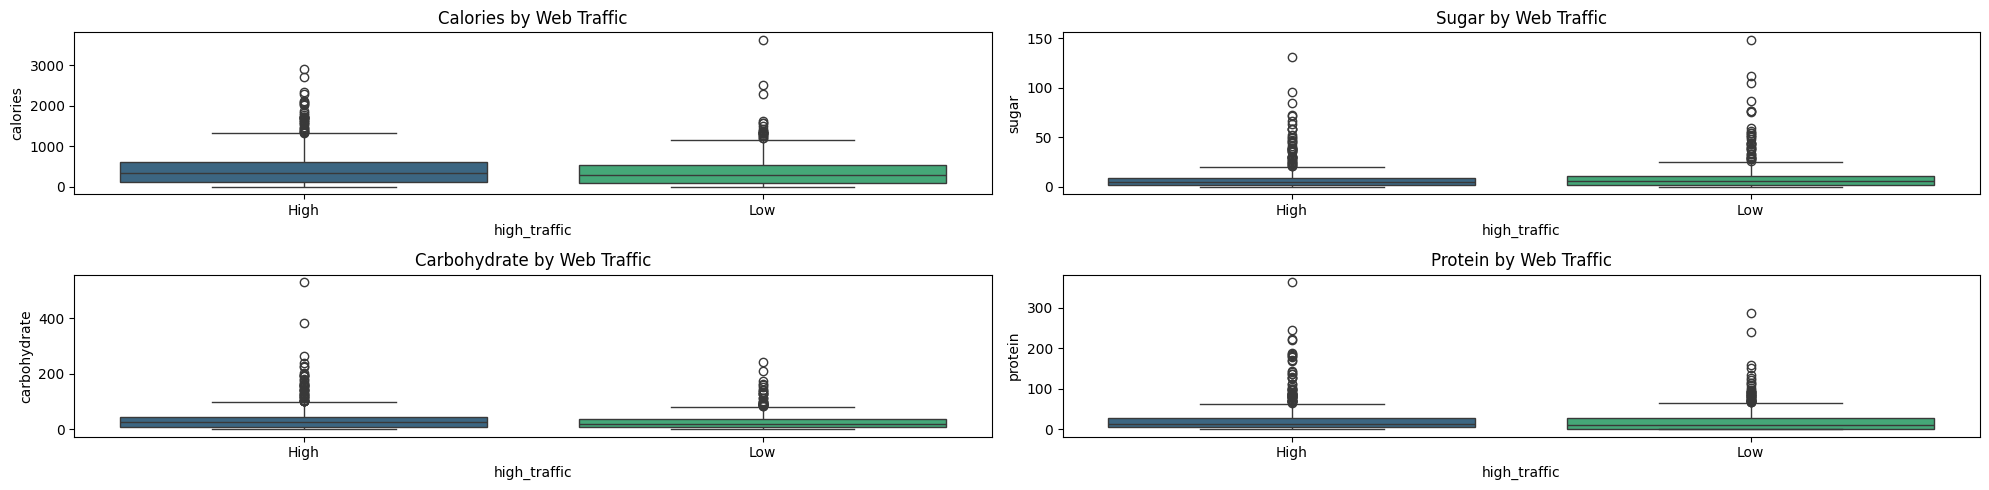

In [94]:
fig, axes = plt.subplots(2,2,figsize=(20,5))
sns.boxplot(data=df, x='high_traffic', y='calories', hue='high_traffic', legend=False, palette='viridis', ax=axes[0,0]).set(title="Calories by Web Traffic")
sns.boxplot(data=df, x='high_traffic', y='sugar', hue='high_traffic', legend=False, palette='viridis', ax=axes[0,1]).set(title="Sugar by Web Traffic")
sns.boxplot(data=df, x='high_traffic', y='carbohydrate', hue='high_traffic', legend=False, palette='viridis', ax=axes[1,0]).set(title="Carbohydrate by Web Traffic")
sns.boxplot(data=df, x='high_traffic', y='protein', hue='high_traffic', legend=False, palette='viridis', ax=axes[1,1]).set(title="Protein by Web Traffic")
plt.tight_layout()
plt.show()

The boxplots are showing a lot of outliers. The inerquartiles and meadean values seem to match across web traffic.

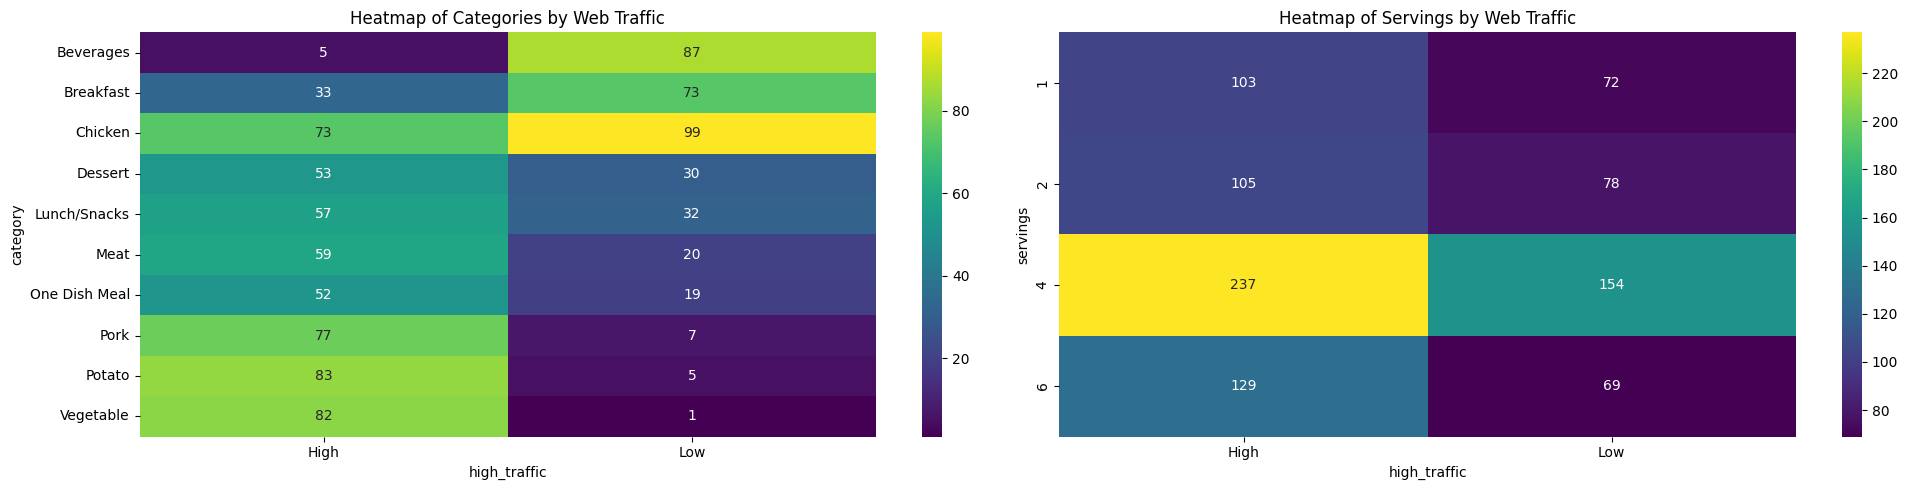

In [93]:
# Looking for any correlations between th target the the category features

# Create a contingency tables
category_traffic_contingency_table = pd.crosstab(df['category'], df['high_traffic'])
servings_traffic_contingency_table = pd.crosstab(df['servings'], df['high_traffic'])

# Plot the heatmap
fig, axes = plt.subplots(1,2,figsize=(20,5))
sns.heatmap(category_traffic_contingency_table, annot=True, fmt='d', cmap='viridis', ax=axes[0]).set(title='Heatmap of Categories by Web Traffic')
sns.heatmap(servings_traffic_contingency_table, annot=True, fmt='d', cmap='viridis', ax=axes[1]).set(title='Heatmap of Servings by Web Traffic')
plt.tight_layout()
plt.show()

- There is a stronger correlatin between catgories and web traffic. Vegetable, Potato, Pork, One Dish Meal, Meat are the top 5 categories that drive High web traffic.  This is interesting because the fewest of the recipes are in the "One Dish Meal" category.
- There are more 4 serving recipes and most of them drive High web traffic.

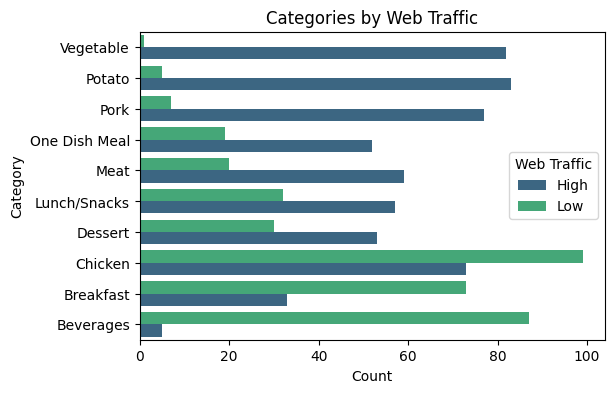

In [89]:
# Count the occurrences of each category and High_traffic combination
category_traffic_counts = df.groupby(['category', 'high_traffic']).size().reset_index(name='counts')

# Create the bar plot
plt.figure(figsize=(6, 4))
barplot = sns.barplot(data=category_traffic_counts, x='counts', y='category', hue='high_traffic', palette='viridis')

plt.title('Categories by Web Traffic')
plt.xlabel('Count')
plt.ylabel('Category')

# Update the legend title
handles, labels = barplot.get_legend_handles_labels()
barplot.legend(handles, labels, title='Web Traffic')

plt.gca().invert_yaxis()  # High traffic at the top
plt.show()


- Another view that shows Vegetable, Potato, Pork, One Dish Meal, Meat are the top 5 categories that drive High web traffic.
- The top 5 categories are also the lowest in contributing to the low traffic.
- Chicken also drives high traffic **but** more than likely drives low traffic as well.


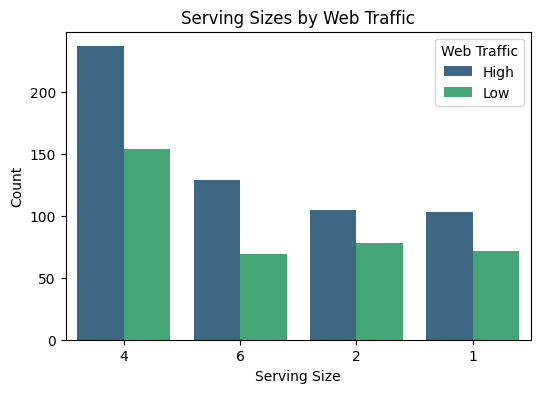

In [92]:
# Count the occurrences of each serving size and High_traffic combination
serving_size_traffic_counts = df.groupby(['servings', 'high_traffic']).size().reset_index(name='counts')

plt.figure(figsize=(6, 4))

# Create the bar plot
barplot = sns.barplot(data=serving_size_traffic_counts, y='counts', x='servings', order = df['servings'].value_counts().index, hue='high_traffic', palette='viridis')

# Set plot title and labels
plt.title('Serving Sizes by Web Traffic')
plt.ylabel('Count')
plt.xlabel('Serving Size')

# Update the legend title
handles, labels = barplot.get_legend_handles_labels()
barplot.legend(handles, labels, title='Web Traffic')

# Show the plot
plt.show()

Most of the High traffic recipes have 4 serving sizes.

### Model Development

#### Summary:
- Considering the `high_traffic` feature is the target variable and there are only two options, Low or High, the models will be trained for a **binary classification** problem.
- The baseline model is a simple Logistic Regression model with regularization to handle outliers better.
- The comparison model is an ensemble model, Random Forest, which is also less sensitive to outliers.
- Encoded the `category` feature to numeric values.
- Encoded the target, `high_traffic`, to a numeric boolean.
- Using the pipelines to ensure any transformation on X_train and automatically done to X_test.
- Split the data with 80% training data and 20% test data, stratified.
- Used log transformation for the numeric columns [Calories, Carbohydrate, Sugar, Protein] to make their right-skewed distributions less skewed.


In [95]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,435.939196,35.069676,9.046547,24.149296,Pork,6,High
2,35.480000,38.560000,0.660000,0.920000,Potato,4,High
3,914.280000,42.680000,3.090000,2.880000,Breakfast,1,Low
4,97.030000,30.560000,38.630000,0.020000,Beverages,4,High
5,27.050000,1.850000,0.800000,0.530000,Beverages,4,Low


In [96]:
# Encoding the high_traffic feature
df['high_traffic'] = df['high_traffic'].map({'High': 1, 'Low': 0})
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,435.939196,35.069676,9.046547,24.149296,Pork,6,1
2,35.480000,38.560000,0.660000,0.920000,Potato,4,1
3,914.280000,42.680000,3.090000,2.880000,Breakfast,1,0
4,97.030000,30.560000,38.630000,0.020000,Beverages,4,1
5,27.050000,1.850000,0.800000,0.530000,Beverages,4,0


In [97]:
X = df.drop('high_traffic', axis=1)
y = df['high_traffic']
X.shape, y.shape

((947, 6), (947,))

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((757, 6), (757,), (190, 6), (190,))

In [101]:
# Create list of num cols
num_cols = ['calories','carbohydrate','sugar','protein']

# Create Numeric Transformer
numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', RobustScaler())
])

# Create Column Transformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_cols),
        ('cat', OneHotEncoder(), ['category'])
    ],
    remainder='passthrough'  # Pass through any columns not specified in transformers
)

#### Baseline Model Pipeline

In [102]:
# Define Pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', random_state=42))
])

# Train the model
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['calories', 'carbohydrate',
                                                   'sugar', 'protein']),
                                                 ('cat', OneHotEncoder(),
                                                  ['category'])])),
                ('classifier', LogisticRegression(random_state=42))])

##### Feature Importance

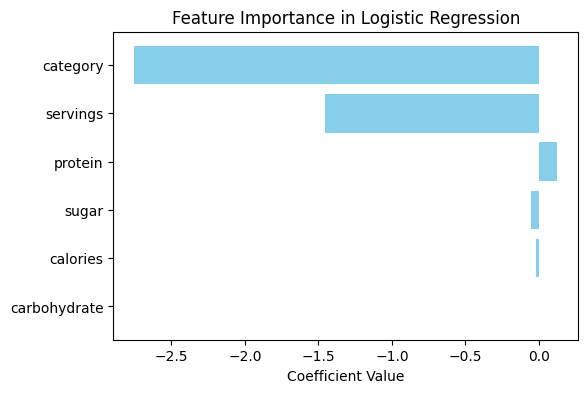

In [104]:
# Extract the classifier from the pipeline
classifier = baseline_pipeline.named_steps['classifier']

# Extract the coefficients and match them to the feature names
coefficients = classifier.coef_.flatten()
feature_importances = dict(zip(X.columns, coefficients))

# Sort features by importance
sorted_features = sorted(feature_importances.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Extract sorted feature names and their corresponding coefficients
sorted_feature_names, sorted_coefficients = zip(*sorted_features)

# Plot the feature importances
plt.figure(figsize=(6, 4))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

According to the Logsitic Regression model, category and servings have strong negative correlations with the target, high traffic. Protein, sugar, calories have weak correaltinos.  Protein has the only positive correlations.

#### Comparison Model Pipeline

In [105]:
# Define Pipeline
comparison_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42))
])

# Train the model
comparison_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['calories', 'carbohydrate',
                                                   'sugar', 'protein']),
                                                 ('cat', OneHotEncoder(),
                                                  ['category'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=1000,
                                        random_state=42))])

##### Feature Importance

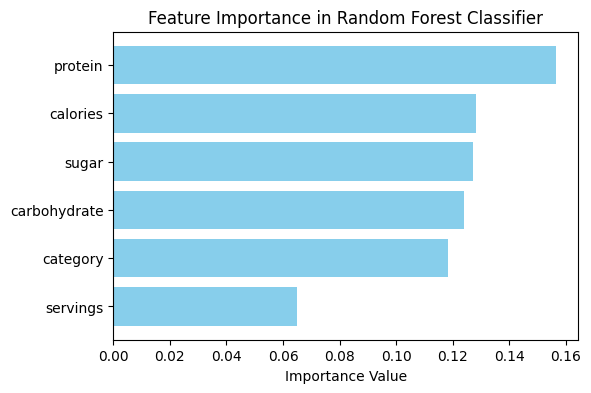

In [106]:
# Extract the classifier from the pipeline
classifier = comparison_pipeline.named_steps['classifier']

# Extract feature importances from the classifier
importances = classifier.feature_importances_

# Create a dictionary of feature importances
feature_importances = dict(zip(X.columns, importances))

# Sort features by importance
sorted_features = sorted(feature_importances.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Extract sorted feature names and their corresponding importances
sorted_feature_names, sorted_importances = zip(*sorted_features)

# Plot the feature importances
plt.figure(figsize=(6, 4))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importance Value')
plt.title('Feature Importance in Random Forest Classifier')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

According to the Random Forest Classifier there are a lot more positive correlations with the target than the Logistic Regression and the EDA.

### Model Evaluation

#### Summary:

- **Baseline Model (Logistic Regression) Results:**
  - **Precision for High Traffic (0.85):** Of the recipes predicted as high traffic, 85% are indeed high traffic.
  - **Recall for High Traffic (0.77):** 77% of the actual high traffic recipes were correctly identified.
  - **F1-Score for High Traffic (0.81):** This score balances precision and recall.

- **Comparison Model (Random Forest Classifier) Results:**
  - **Precision for High Traffic (0.82):** Of the recipes predicted as high traffic, 82% are indeed high traffic.
  - **Recall for High Traffic (0.80):** 80% of the actual high traffic recipes were correctly identified.
  - **F1-Score for High Traffic (0.81):** This score balances precision and recall.

Based on the results and the business requirement of "Correctly predict high traffic recipes 80% of the time," the best-performing model is the Comparison Model (Random Forest Classifier).


In [126]:
def metrics_score(actual:pd.Series, predicted:np.ndarray, fig_size:tuple[int, int]=(6, 4)) -> None:
  """Plots the confusion matrix

    Parameters:
      actual(series): actual predictions
      predicted(ndarray): predicated predications

    Returns:
      None

  """
  print(classification_report(actual, predicted, target_names=['Low Traffic','High Traffic']))
  cm = confusion_matrix(actual, predicted)

  plt.figure(figsize = fig_size)

  labels = ['Low Traffic', 'High Traffic']

  sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels=labels, yticklabels=labels)

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

#### Baseline Confusion Matrix

              precision    recall  f1-score   support

 Low Traffic       0.69      0.79      0.74        75
High Traffic       0.85      0.77      0.81       115

    accuracy                           0.78       190
   macro avg       0.77      0.78      0.77       190
weighted avg       0.79      0.78      0.78       190



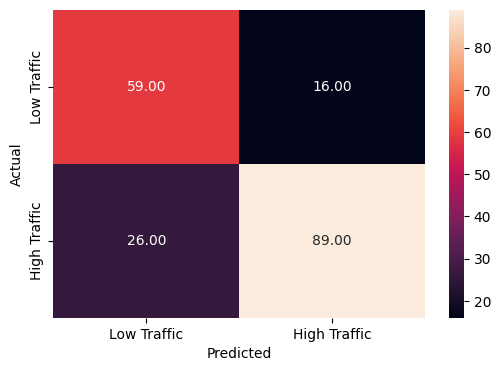

In [127]:
# Make predictions
y_pred_baseline = baseline_pipeline.predict(X_test)

# Evaluate the model
metrics_score(y_test, y_pred_baseline)

- Recall for high traffic is the percentage of actual high traffic recipes that the model correctly identified. It is 77%, which **does not** meet the business requirement of 80%.

- Precision for high traffic is the percentage of recipes predicted to be high traffic that are actually high traffic. At 85%, this is quite good and minimizes the possibility of choosing recipes that lead to low traffic.

- F1 Score is the balance between Recall and Precision, providing a single metric to evaluate the model's performance. The F1 Score for high traffic is 81%.

#### Comparison Confusion Matrix

              precision    recall  f1-score   support

 Low Traffic       0.71      0.72      0.72        75
High Traffic       0.82      0.81      0.81       115

    accuracy                           0.77       190
   macro avg       0.76      0.76      0.76       190
weighted avg       0.77      0.77      0.77       190



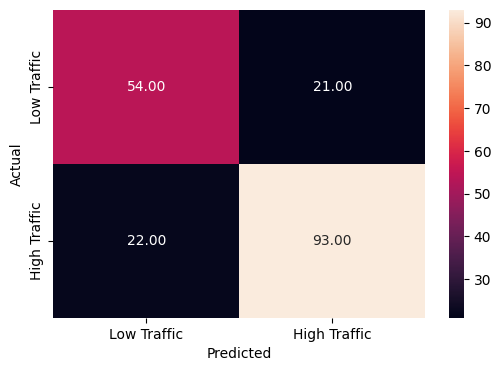

In [128]:
# Make predictions
y_pred_comparison = comparison_pipeline.predict(X_test)

# Evaluate the model
metrics_score(y_test, y_pred_comparison)

- Recall for high traffic is the percentage of actual high traffic recipes that the model correctly identified. It is 81%, which **does** meet the business requirement of 80%.

- Precision for high traffic is the percentage of recipes predicted to be high traffic that are actually high traffic. At 82%, this is quite good and minimizes the possibility of choosing recipes that lead to low traffic.

- F1 Score is the balance between Recall and Precision, providing a single metric to evaluate the model's performance. The F1 Score for high traffic is 81%.

### Metric for the Buisiness to Monitor

* How should the buisiness monitor what they want to achieve?
  * The key metrics to monitor are ...
    1.   **Recall**: This metric is crucial to ensure that a significant portion, 80%, of actual high traffic recipes are identified.
    2.   **Precision**: This will help the business understand how often the recipes predicted to be high traffic are indeed high traffic and minimizes the possibility of choosing recipes that lead to low traffic.
    3.   **F1-Score**: As a balance between precision and recall, this metric will give a single measure of the model’s overall performance.
  * The buisness should use...
    * **Real-time Dashboards**: Use tools like Tableau, Power BI, or custom dashboards to visualize and monitor these key metrics in real time.
    * **Automated Reports**: Set up automated reports that provide regular updates on these metrics. This could be daily, weekly, or monthly, depending on the business need.
    * **Alert Systems**: Implement alert systems that notify the team when metrics fall below a certain threshold, allowing for immediate action.


---

* Current Metrics for the best performing model, Random Forest Classifier:
  * Precision for High Traffic: 82%
  * Recall for High Traffic: 81%
  * F1-Score for High Traffic: 81%
  * Accuracy: 77%

### Final Summary


*   The dataset needed some cleaning, missing values, typos, etc. where all handled.
*   The data is imbalanced due to data having singnicantly more the high traffic recipes than low traffic recipes.
*   There is a strong correlation between category and web traffic.
*   There are weak correlaions between the numeric features and web traffic.
*   The best performing model is the Random Forest Classifier. It meets the business requirement with a recall metric of 81%, ensuring that 81% of actual high traffic recipes are correctly identified. Additionally, the precision of 81% minimizes the likelihood of selecting a recipe that leads to low traffic.
- Recipes that will lead to high traffic are...
  * 4-serving recipes in the following categories..
    1. Vegetable
    2. Potato
    3. Pork
    4. One Dish Meal
    5. Meat



---

####Suggestions:

*To help choose the recipes that drive the highest traffic, follow these suggestions:*

* **Top Recipes that Lead to High Traffic:**
  * Add more 4-serving Vegetable, Potato, Pork, One Dish Meal, and Meat recipes. The One Dish Meal category, which is among the top 5 high traffic drivers, currently has the least number of recipes.

* **Collect More Data:**
  * The current dataset is small and imbalanced. Gathering more data will likely improve the model's performance and provide more accurate predictions.

* **Deploy the Model:**
  * Deploy the model in the cloud or a platform that supports an API to initiate the inference pipeline and automatically deliver popular recipes to the Food Discovery web application.

* **Regular Model Evaluation:**
  * Periodically re-evaluate the model using fresh data to ensure it continues to perform well. This will help maintain the model's accuracy and relevance.

* **Feedback Loops:**
  * Implement a system for gathering feedback from stakeholders and users to continuously improve the model and its predictions. This feedback will be invaluable for making iterative improvements to the model.
